Logistic Regression Accuracy: 0.7349 
────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        21
           B       0.56      0.61      0.58        54
           C       0.57      0.65      0.61        78
           D       0.58      0.43      0.50        83
           F       0.87      0.95      0.91       243

    accuracy                           0.73       479
   macro avg       0.51      0.53      0.52       479
weighted avg       0.70      0.73      0.71       479



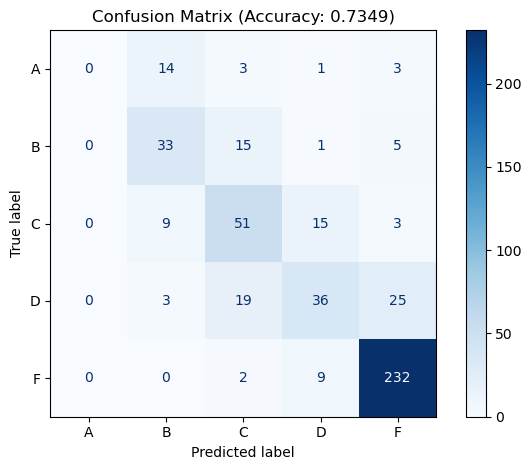

First 20 Predictions with Risk Assessment:


,StudentID,ActualGrade,PredictedGrade,Match,RiskLevel
0,2594,F,F,True,At-Risk
1,2832,F,F,True,At-Risk
2,2568,F,F,True,At-Risk
3,2203,F,F,True,At-Risk
4,1674,F,F,True,At-Risk
5,1577,F,F,True,At-Risk
6,2484,F,F,True,At-Risk
7,1297,B,B,True,On Track
8,2320,F,F,True,At-Risk
9,2026,F,F,True,At-Risk


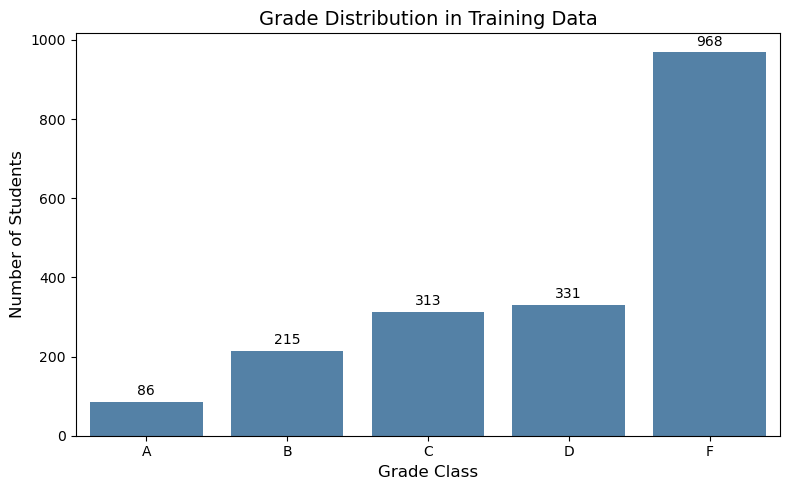


Correct vs Incorrect Predictions by Grade:


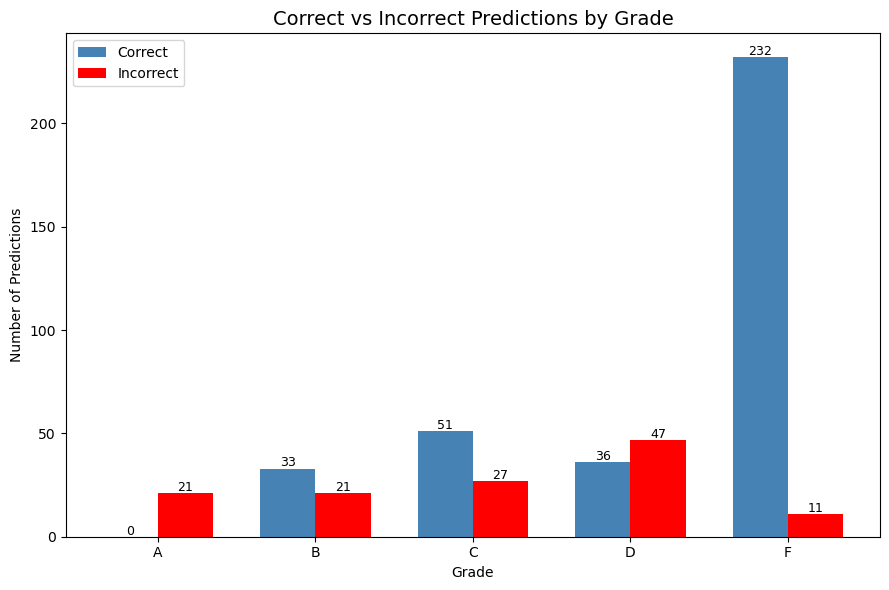

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import pickle
import os
import warnings
from sklearn.exceptions import ConvergenceWarning

# Optional: silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load your data
train_data = pd.read_csv("../Data/train_data.csv")
test_data = pd.read_csv("../Data/test_data.csv")

# Separate features and labels
X_train = train_data.drop(columns=["GradeClass", "GPA", "StudentID"])
y_train = train_data["GradeClass"].astype(int)

X_test = test_data.drop(columns=["GradeClass", "GPA", "StudentID"])
y_test = test_data["GradeClass"].astype(int)

# Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Save model and scaler to ../Artifacts/Models
output_model_path = "../Artifacts/PLK"
os.makedirs(output_model_path, exist_ok=True)

with open(os.path.join(output_model_path, "logistic_model.pkl"), "wb") as f:
    pickle.dump(model, f)

with open(os.path.join(output_model_path, "logistic_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Grade mapping
grade_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}
y_test_letters = pd.Series(y_test).map(grade_map)
y_pred_letters = pd.Series(y_pred).map(grade_map)
label_names = [grade_map[i] for i in sorted(grade_map)]

# Evaluation
accuracy = accuracy_score(y_test_letters, y_pred_letters)
print("Logistic Regression Accuracy:", round(accuracy, 4), "\n────────────────────────────────────")
print("\nClassification Report:")
print(classification_report(y_test_letters, y_pred_letters, target_names=label_names, zero_division=0))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

# Create prediction comparison table
comparison_df = test_data[["StudentID", "GradeClass"]].copy()
comparison_df["Predicted"] = y_pred
comparison_df["ActualGrade"] = comparison_df["GradeClass"].astype(int).map(grade_map)
comparison_df["PredictedGrade"] = pd.Series(y_pred).astype(int).map(grade_map)
comparison_df["Match"] = comparison_df["ActualGrade"] == comparison_df["PredictedGrade"]

# Add RiskLevel column using improved phrasing
def classify_risk(grade):
    return "On Track" if grade <= 2 else "At-Risk"

comparison_df["RiskLevel"] = comparison_df["Predicted"].apply(classify_risk)
comparison_df = comparison_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save prediction table
os.makedirs("../Artifacts/Predictions", exist_ok=True)
comparison_df.to_csv("../Artifacts/Predictions/prediction_results_logistic.csv", index=False)

# Display sample
try:
    from IPython.display import display

    def highlight_row_style(row):
        if row["RiskLevel"] == "At-Risk":
            return ['background-color: red; color: white'] * len(row)
        elif row["Match"] == False:
            styles = []
            for col in row.index:
                if col == "Match":
                    styles.append("color: red; background-color: black")
                else:
                    styles.append("background-color: black; color: white")
            return styles
        else:
            return ['background-color: black; color: white'] * len(row)

    print("First 20 Predictions with Risk Assessment:")
    display(comparison_df[["StudentID", "ActualGrade", "PredictedGrade", "Match", "RiskLevel"]]
            .head(20)
            .style.apply(highlight_row_style, axis=1))
except:
    print("\nFirst 20 Predictions:")
    print(comparison_df[["StudentID", "ActualGrade", "PredictedGrade", "Match", "RiskLevel"]]
          .head(20).to_string(index=False))

# Final Grade Distribution Plot
plt.figure(figsize=(8, 5))
grade_counts = train_data["GradeClass"].astype(int).value_counts().sort_index()
grade_labels = ['A', 'B', 'C', 'D', 'F']
sns.barplot(x=grade_labels, y=grade_counts.values, color='steelblue')
for i, count in enumerate(grade_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Grade Distribution in Training Data", fontsize=14)
plt.xlabel("Grade Class", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.tight_layout()
plt.show()

# Split prediction results
comparison_df["Match"] = comparison_df["ActualGrade"] == comparison_df["PredictedGrade"]

# Count correct predictions per grade
correct_counts = comparison_df[comparison_df["Match"] == True]["ActualGrade"].value_counts().reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0)

# Count incorrect predictions per grade
incorrect_counts = comparison_df[comparison_df["Match"] == False]["ActualGrade"].value_counts().reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0)

# Build summary DataFrame
dual_summary_df = pd.DataFrame({
    "Grade": ['A', 'B', 'C', 'D', 'F'],
    "Correct": correct_counts.values,
    "Incorrect": incorrect_counts.values
})

# Display side-by-side table
print("\nCorrect vs Incorrect Predictions by Grade:")

# Plot dual bar chart
x = np.arange(len(dual_summary_df["Grade"]))  # positions
width = 0.35  # bar width

plt.figure(figsize=(9, 6))
plt.bar(x - width/2, dual_summary_df["Correct"], width=width, label='Correct', color='steelblue')
plt.bar(x + width/2, dual_summary_df["Incorrect"], width=width, label='Incorrect', color='red')

# Add counts above bars
for i in range(len(x)):
    plt.text(x[i] - width/2, dual_summary_df["Correct"][i] + 1, str(dual_summary_df["Correct"][i]), ha='center', fontsize=9)
    plt.text(x[i] + width/2, dual_summary_df["Incorrect"][i] + 1, str(dual_summary_df["Incorrect"][i]), ha='center', fontsize=9)

plt.title("Correct vs Incorrect Predictions by Grade", fontsize=14)
plt.xlabel("Grade")
plt.ylabel("Number of Predictions")
plt.xticks(x, dual_summary_df["Grade"])
plt.legend()
plt.tight_layout()
plt.show()
